In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist  # Import Fashion MNIST dataset
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, classification_report
import seaborn as sns

In [3]:
# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

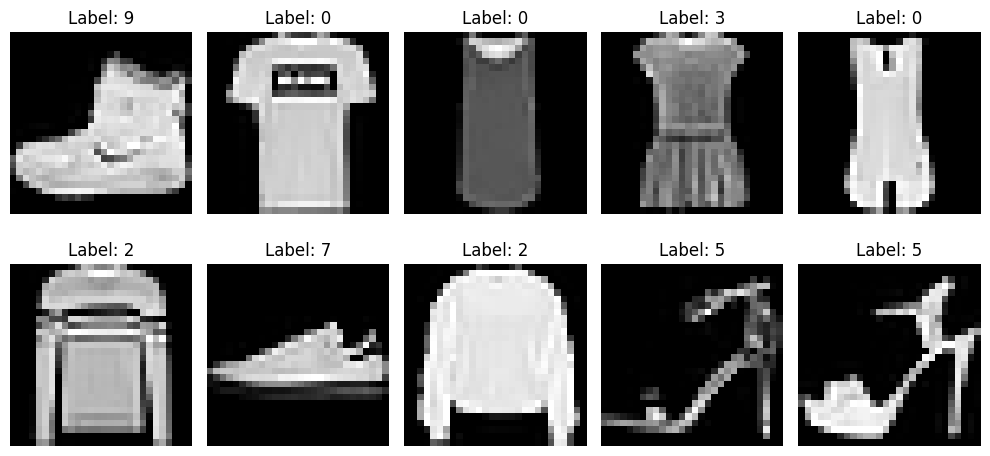

In [4]:

# Visualize sample images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(x_train[i], cmap='gray')
    axes[i].set_title(f"Label: {y_train[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
# Define the Residual Block
def residual_block(x, filters, kernel_size=3, stride=1, activation='relu'):
    # First convolutional layer in the residual block
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)

    # Second convolutional layer in the residual block
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(y)
    y = layers.BatchNormalization()(y)

    # Skip connection to add the input to the output
    if stride != 1 or x.shape[-1] != filters:
        x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    y = layers.Add()([x, y])

    # Activation function after the addition
    y = layers.Activation(activation)(y)

    return y

In [7]:
# Build the ResNet model
def build_resnet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolutional layer with batch normalization and activation
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Max pooling layer
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Three residual blocks
    for _ in range(3):
        x = residual_block(x, 64)

    # Global average pooling layer
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layer for classification
    x = layers.Dense(num_classes, activation='softmax')(x)

    # Build the model
    model = models.Model(inputs, x)
    return model

In [8]:
# Define input shape and number of classes
input_shape = (28, 28, 1)  # Fashion MNIST images are 28x28
num_classes = 10  # There are 10 classes in Fashion MNIST

In [9]:
# Reshape images for the model
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

In [10]:
# Build and compile the model
model = build_resnet(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
model.fit(x_train, y_train, epochs=1, batch_size=200, validation_data=(x_test, y_test))

300/300 [==============================] - 162s 531ms/step - loss: 0.5440 - accuracy: 0.8046 - val_loss: 4.3967 - val_accuracy: 0.2216


In [12]:
# Predictions on the test set
y_pred = model.predict(x_test)

# Convert from One Hot Encoding to int values that represent int labels
true_labels = np.argmax(y_test, axis=1)
pred_labels = np.argmax(y_pred, axis=1)

313/313 [==============================] - 8s 26ms/step


In [13]:
# Print precision, recall, and F1-score
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

print('Precision Score:', precision)
print('Recall Score:', recall)
print('F1 Score:', f1)

Precision Score: 0.09526225073227035
Recall Score: 0.22160000000000002
F1 Score: 0.12385004339493477


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[467   0  14   0   0   0  12   0 507   0]
 [275   0 193   0   0   0 524   0   8   0]
 [ 11   0 665   0   0   0  25   0 299   0]
 [736   0  55   0   0   0 100   0 109   0]
 [ 52   0 407   0   0   0  50   0 491   0]
 [115   0   3   0   0   0  50   0 832   0]
 [165   0 276   0   0   0  99   0 460   0]
 [  3   0   0   0   0   0   0   0 997   0]
 [  3   0   0   0   0   0  12   0 985   0]
 [  8   0   4   0   0   0   2   0 986   0]]


<Axes: >

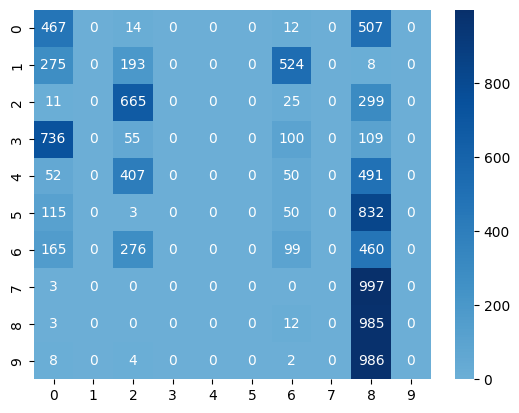

In [14]:
# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
print('Confusion Matrix:')
print(cm)

# Plot the Confusion Matrix
sns.heatmap(cm, center=True, annot=True, fmt="d", cmap="Blues")

In [15]:
# Classification Report
report = classification_report(true_labels, pred_labels)
print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.47      0.33      1000
           1       0.00      0.00      0.00      1000
           2       0.41      0.67      0.51      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.11      0.10      0.11      1000
           7       0.00      0.00      0.00      1000
           8       0.17      0.98      0.30      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.22     10000
   macro avg       0.10      0.22      0.12     10000
weighted avg       0.10      0.22      0.12     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
